# CrowdTruth metrics 2.0 documentation

Let:

* $workers(u):$ all workers that annotate media unit $u$;
* $units(i):$ all input media units annotated by worker $i$;
* $WorkVec(i, u):$ annotations of worker $i$ on media unit $u$ as a binary vector;
* $MediaUnitVec(s) = \sum_{i \in workers(s)} WorkVec(i,s)$, where $s$ is an input media unit.

## Media Unit Quality Score (UQS)

The unit quality score $UQS(u)$ is computed as the average cosine similarity between all worker vectors for a given input media unit $u$, weighted by the worker quality ($WQS$) and annotation quality ($AQS$). The goal is to capture the degree of agreement in annotating the media unit. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score.

$$ UQS(u) = \frac{\sum_{i, j \in workers(u)} Wcos(WorkVec(i,u), WorkVec(j,u)) \; WQS(i) \; WQS(j)}{\sum_{i, j \in workers(u)} WQS(i) \; WQS(j)}, \; i \neq j.$$


### Weighted Cosine

To weigh the metrics with the annotation quality, we compute $Wcos$, the weighted version of the cosine similarity. This metric is only applicable to closed tasks, where annotation quality can be calculated across media units. For open-ended tasks, we consider annotation quality equal to 1 and calculate the regular cosine similarity.

$$ Wcos(vec_1, vec_2) = \frac{\sum_{a} vec_1(a) \; vec_2(a) \; AQS(a)}{\sqrt{(\sum_{a} vec_1^2(a) \; AQS(a)) \; (\sum_{a} vec_2^2(a) \; AQS(a))}} .$$ 


## Worker Quality Score (WQS)

The worker quality score $WQS(i)$ for a given worker $i$ is the product of 2 separate metrics - the worker-worker agreement $WWA(i)$ and the worker-media unit agreement $WUA(i)$.

$$ WQS(i) = WUA(i) \; WWA(i) .$$

### Worker-Media Unit Agreement

The worker-media unit agreement $WUA(i)$ is the average cosine distance between the annotations of a worker $i$ and all annotations for the media units they have worked on, weighted by the media unit and annotation quality. It calculates how much a worker disagrees with the crowd on a media unit basis. Through the weighted average, media units and anntation with lower quality will have less of an impact on the final score.

$$ WSA(i) = \frac{\sum_{u \in units(i)} Wcos(WorkVec(i,u), MediaUnitVec(u) - WorkVec(i, u)) \; UQS(u)}{\sum_{u \in units(i)} UQS(u)} .$$

### Worker-Worker Agreement

The worker-worker agreement $WWA(i)$ is the average cosine distance between the annotations of a worker $i$ and all other workers that have worked on the same media units as worker $i$, weighted by the worker and annotation qualities. The metric gives an indication as to whether there are consisently like-minded workers. This is useful for identifying communities of thought. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score of the given worker.

$$ WWA(i) = \frac{ \sum_{j \in workers(u \in units(i))} Wcos(WorkVec(i, u), WorkVec(j, u)) \; WQS(j) \; UQS(u) }{ \sum_{j \in workers(s \in units(i))} WQS(j) \; UQS(u) }, \; i \neq j .$$


## Annotation Quality Score (AQS)

The annotation quality score $AQS(a)$ calculates the agreement of selecting an annotation $a$, over all the media units it appears in. Therefore, it is only applicable to closed tasks, where the same annotation set is used for all input media units. It is based on $P_a(i | j)$, the probability that if a worker $j$ annotates $a$ in a media unit, worker $i$ will also annotate it. 

$$ P_a(i | j) = \frac{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(i, s)(r) \; WorkVec(j, s)(r) }{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(j, u)(r) } . $$

$AQS(a)$ is the weighted average of $P_a(i | j)$ for all possible pairs of workers. Through the weighted average, input media units and workers with lower quality will have less of an impact on the final score of the annotation.

$$ AQS(a) = \frac{ \sum_{i,j} WQS(i) \; WQS(j) \; P_a(i | j) }{ \sum_{i,j} WQS(i) \; WQS(j) }, i \neq j . $$


## Media Unit-Annotation Score (UAS)

The media unit - annotation score $UAS(u, a)$ calculates the likelihood that annotation $a$ is expressed in input media unit $u$. It is the ratio of the number of workers that picked annotation $u$ over all workers that annotated the unit, weighted by the worker quality.

$$ UAS(u, a) = \frac{ \sum_{i \in workers(u)} WorkVec(i,u)(a) \; WQS(i) }{ \sum_{i \in workers(u)} WQS(i) }. $$

# How to run the metrics

In [1]:
# !pip install crowdtruth

import crowdtruth
from crowdtruth.configuration import DefaultConfig
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

class config(DefaultConfig):
    inputColumns = ["term1", "b1", "e1", "term2", "b2", "e2", "sentence"]
    outputColumns = ["relations"]
    
    # processing of a closed task
    open_ended_task = False
    annotation_separator = " "
    annotation_vector = [
        "causes", "manifestation", "treats", "prevents", "symptom", "diagnose_by_test_or_drug", "location",
        "side_effect", "contraindicates", "associated_with", "is_a", "part_of", "other", "none"
    ]
    
    def processJudgments(self, judgments):
        # any pre-processing of the input data goes here
        for col in self.outputColumns:
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
        return judgments

Creating a class that inherits from `Configuration` lets us define how the input file will be processed:

* `inputColumns`: list of input columns from the .csv file, the input that the workers were shown
* `outputColumns`: list of output columns with the answers from the workers
* `processJudgments`: function that defines how the worker judgments wil be processed; default separator for judgments is ','

To build the annotation vector, we also need to specify whether this is an **open-ended** or **closed** task, using the `open_ended_task` variable.

* **open-ended task** means that the annotation space is not known, and workers can freely provide all the choices that apply (e.g. in sound tagging, the workers are provided with a text box to enter all tags they can think of)
* **closed task** means that the annotations that can occur in the data are already known, and the workers are asked to validate their existence (e.g. for medical relation extraction, the workers pick from a pre-defined multiple-choice set of relations)

If the task we are processing is **closed**, then we also need to provide the list of possible annotations in the `annotation_vector` variable.

In [2]:
# Read data
data, config = crowdtruth.load(
    file = "relex_example.csv",
    config = config()
)

data['judgments'].head()

INFO:root:Config loaded
INFO:root:Values not stored as dictionary


,output.relations,submitted,started,worker,unit,duration,job
judgment,,,,,,,
1321074821,"{u'associated_with': 1, u'causes': 0, u'manife...",2014-07-11 23:53:21,2014-07-11 23:53:03,15848372,502540300,18,relex_example
1321080494,"{u'is_a': 1, u'causes': 0, u'manifestation': 0...",2014-07-12 00:04:01,2014-07-12 00:02:53,25990856,502540300,68,relex_example
1321082343,"{u'part_of': 1, u'causes': 0, u'manifestation'...",2014-07-12 00:07:10,2014-07-12 00:06:34,25224036,502540300,36,relex_example
1321098346,"{u'is_a': 1, u'causes': 0, u'manifestation': 0...",2014-07-12 00:36:08,2014-07-12 00:35:11,13763729,502540300,57,relex_example
1321104806,"{u'symptom': 1, u'causes': 0, u'manifestation'...",2014-07-12 00:51:54,2014-07-12 00:50:47,8888883,502540300,67,relex_example


In [3]:
results = crowdtruth.run(data, config)

INFO:root:1 iterations; max d= 1.0 ; wqs d= 0.804813203931; sqs d= 0.675174006342; rqs d= 0.782716968453
INFO:root:2 iterations; max d= 0.373595823847 ; wqs d= 0.18552735073; sqs d= 0.0999762548168; rqs d= 0.065519897197
INFO:root:3 iterations; max d= 0.0681409887463 ; wqs d= 0.0207659203558; sqs d= 0.0170501540939; rqs d= 0.0107034697269
INFO:root:4 iterations; max d= 0.067748434946 ; wqs d= 0.0128209941329; sqs d= 0.00507760818222; rqs d= 0.00346934024723
INFO:root:5 iterations; max d= 0.0149750705113 ; wqs d= 0.001755371176; sqs d= 0.0015292862114; rqs d= 0.00122480420571
INFO:root:6 iterations; max d= 0.00595215799549 ; wqs d= 0.00115667719405; sqs d= 0.000627373802498; rqs d= 0.000390160430645
INFO:root:7 iterations; max d= 0.00246299055575 ; wqs d= 0.000238674367565; sqs d= 0.000166045739903; rqs d= 0.00013851140923
INFO:root:8 iterations; max d= 0.0009189351074 ; wqs d= 0.000126251399396; sqs d= 8.91603091999e-05; rqs d= 5.43500254714e-05


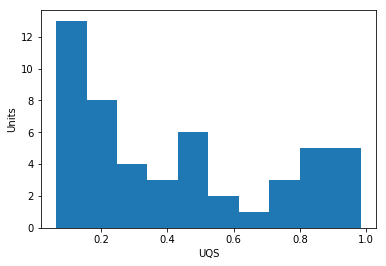

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results["units"]["uqs"])
plt.xlabel("UQS")
plt.ylabel("Units")

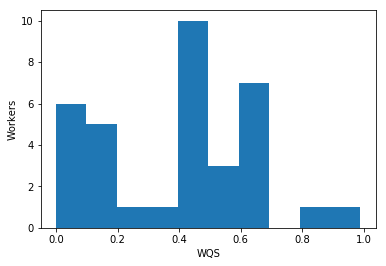

In [5]:
plt.hist(results["workers"]["wqs"])
plt.xlabel("WQS")
plt.ylabel("Workers")

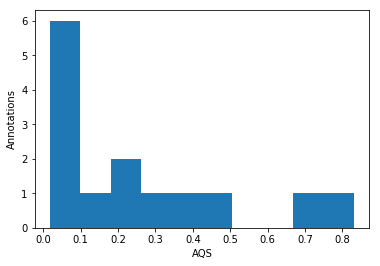

In [6]:
plt.hist(results["annotations"]["aqs"])
plt.xlabel("AQS")
plt.ylabel("Annotations")

In [7]:
results["units"]["unit_annotation_score"]

unit
502540300    {u'part_of': 5.40815398334e-05, u'treats': 0.0...
502540301    {u'part_of': 0.0, u'treats': 0.865445543, u'pr...
502540302    {u'part_of': 5.1878806508e-05, u'treats': 0.0,...
502540303    {u'part_of': 0.0, u'treats': 0.987168186182, u...
502540304    {u'none': 0.0934630672853, u'treats': 0.0, u'p...
502540305    {u'part_of': 4.79121294337e-05, u'treats': 0.0...
502540306    {u'part_of': 0.0696092128465, u'treats': 0.702...
502540307    {u'part_of': 0.071003533224, u'treats': 0.0, u...
502540308    {u'part_of': 0.0, u'treats': 0.0824128463375, ...
502540309    {u'part_of': 0.0282620788446, u'treats': 0.0, ...
502540310    {u'part_of': 0.0, u'treats': 0.717528861892, u...
502540311    {u'part_of': 0.0, u'treats': 0.333761504297, u...
502540312    {u'part_of': 4.31886763732e-05, u'treats': 0.6...
502540313    {u'part_of': 0.0785668363126, u'treats': 0.0, ...
502540314    {u'part_of': 0.0, u'treats': 0.930404608217, u...
502540315    {u'part_of': 0.0, u'symptom': 0.33506